开始在 cuda 上评估 'Train_SwinUnet_v2_lung' 的所有模型...


评估进度:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_32832\827243095.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_


--- 评估结果汇总 ---
Epoch     Val PSNR       Val SSIM       Test PSNR      Test SSIM      
------------------------------------------------------------
1         21.3842        0.3703         21.3797        0.3722         
2         21.8248        0.4112         21.7595        0.4108         
3         21.6431        0.4047         21.6972        0.4097         
4         21.8673        0.4263         21.8744        0.4283         
5         21.9627        0.4351         21.9571        0.4372         
6         22.0771        0.4391         22.0249        0.4401         
7         22.0319        0.4446         22.0112        0.4462         
8         21.9868        0.4454         21.9793        0.4485         
9         22.0299        0.4477         22.0041        0.4495         
10        22.1676        0.4528         22.1292        0.4559         
11        22.1449        0.4516         22.1048        0.4540         
12        22.1907        0.4588         22.1590        0.4603         


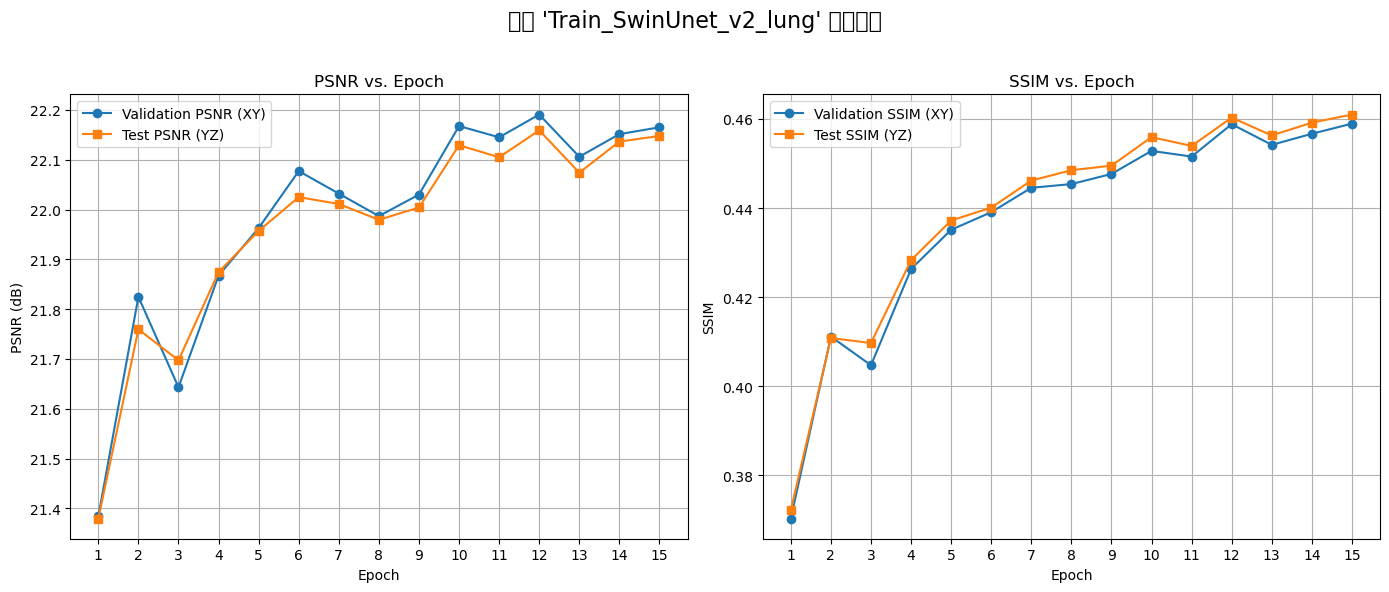

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import cv2
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------------------
# 1. 定义模型和 Dataset 类 (与训练时完全一致)
# ----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.up4, self.dec4 = UpBlockPixelShuffle(encoder_channels[3], 512), DoubleConv(encoder_channels[2] + 512, 512)
        self.up3, self.dec3 = UpBlockPixelShuffle(512, 256), DoubleConv(encoder_channels[1] + 256, 256)
        self.up2, self.dec2 = UpBlockPixelShuffle(256, 128), DoubleConv(encoder_channels[0] + 128, 128)
        self.up1, self.dec1 = UpBlockPixelShuffle(128, 64), DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)
    def forward(self, x):
        x_orig = x
        if self.in_ch == 1: x = x.repeat(1, 3, 1, 1)
        features = self.encoder(x)
        e1, e2, e3, e4 = features[0].permute(0, 3, 1, 2), features[1].permute(0, 3, 1, 2), features[2].permute(0, 3, 1, 2), features[3].permute(0, 3, 1, 2)
        u4, d4 = self.up4(e4), self.dec4(torch.cat([self.up4(e4), e3], dim=1))
        u3, d3 = self.up3(d4), self.dec3(torch.cat([self.up3(d4), e2], dim=1))
        u2, d2 = self.up2(d3), self.dec2(torch.cat([self.up2(d3), e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        return self.outc(d1)

class PlainLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder, self.transform = patches_folder, transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns)
    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        inp_t = self.transform(Image.fromarray(up_img))
        tgt_t = self.transform(Image.fromarray(arr))
        return inp_t, tgt_t

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()
checkpoint_dir = "Train_SwinUnet_v2_lung" # <-- 使用SwinUnet的权重文件夹
num_epochs = 15

# 准备 Dataloaders
val_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_xy"
all_val_fns = sorted([f for f in os.listdir(val_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_val_indices = list(range(len(all_val_fns)))
_, val_idxs = train_test_split(all_val_indices, test_size=0.25, random_state=42)
val_dataset = PlainLowHighDataset(val_patches_folder, val_idxs, all_val_fns, transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_xy"
all_test_fns = sorted([f for f in os.listdir(test_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_test_indices = list(range(len(all_test_fns)))
test_dataset = PlainLowHighDataset(test_patches_folder, all_test_indices, all_test_fns, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------------------
# 3. 定义评估函数
# ----------------------------------------
def evaluate_model(model, loader):
    total_psnr = total_ssim = n = 0
    model.eval()
    with torch.no_grad():
        for inp_t, tgt_t in loader:
            inp_t, tgt_t = inp_t.to(device), tgt_t.to(device)
            out_t = model(inp_t)
            
            pred_np = out_t.clamp(0, 1).cpu().squeeze().numpy()
            target_np = tgt_t.cpu().squeeze().numpy()
            
            total_psnr += psnr_metric(target_np, pred_np, data_range=1.0)
            total_ssim += ssim_metric(target_np, pred_np, data_range=1.0, channel_axis=None)
            n += 1
    return total_psnr / n, total_ssim / n

# ----------------------------------------
# 4. 循环评估所有Epoch并记录结果
# ----------------------------------------
epochs = list(range(1, num_epochs + 1))
val_psnrs, val_ssims = [], []
test_psnrs, test_ssims = [], []

print(f"开始在 {device} 上评估 '{checkpoint_dir}' 的所有模型...")

for epoch in tqdm(epochs, desc="评估进度"):
    # 构建权重文件路径，注意文件名格式
    ckpt_path = os.path.join(checkpoint_dir, f"SwinUnet_v2_hf_epoch{epoch:02d}.pth")
    
    # 实例化新模型并加载权重
    model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    
    # 在验证集和测试集上评估
    vp, vs = evaluate_model(model, val_loader)
    tp, ts = evaluate_model(model, test_loader)
    
    # 记录结果
    val_psnrs.append(vp)
    val_ssims.append(vs)
    test_psnrs.append(tp)
    test_ssims.append(ts)

# ----------------------------------------
# 5. 打印表格形式的结果
# ----------------------------------------
print("\n--- 评估结果汇总 ---")
print("="*60)
print(f"{'Epoch':<10}{'Val PSNR':<15}{'Val SSIM':<15}{'Test PSNR':<15}{'Test SSIM':<15}")
print("-"*60)
for i in range(num_epochs):
    print(f"{i+1:<10}{val_psnrs[i]:<15.4f}{val_ssims[i]:<15.4f}{test_psnrs[i]:<15.4f}{test_ssims[i]:<15.4f}")
print("="*60)


# ----------------------------------------
# 6. 绘制结果图表
# ----------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_psnrs, 'o-', label='Validation PSNR (XY)')
plt.plot(epochs, test_psnrs, 's-', label='Test PSNR (YZ)')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_ssims, 'o-', label='Validation SSIM (XY)')
plt.plot(epochs, test_ssims, 's-', label='Test SSIM (YZ)')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.suptitle(f"模型 '{checkpoint_dir}' 性能评估", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2
import timm
from torchvision import transforms

# ----------------------------------------
# 1. 定义与训练时完全一致的模型架构
# ----------------------------------------
# 确保这些定义与您训练模型时的代码完全相同
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.up4, self.dec4 = UpBlockPixelShuffle(encoder_channels[3], 512), DoubleConv(encoder_channels[2] + 512, 512)
        self.up3, self.dec3 = UpBlockPixelShuffle(512, 256), DoubleConv(encoder_channels[1] + 256, 256)
        self.up2, self.dec2 = UpBlockPixelShuffle(256, 128), DoubleConv(encoder_channels[0] + 128, 128)
        self.up1, self.dec1 = UpBlockPixelShuffle(128, 64), DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)
    def forward(self, x):
        x_orig = x
        if self.in_ch == 1: x = x.repeat(1, 3, 1, 1)
        features = self.encoder(x)
        e1, e2, e3, e4 = features[0].permute(0, 3, 1, 2), features[1].permute(0, 3, 1, 2), features[2].permute(0, 3, 1, 2), features[3].permute(0, 3, 1, 2)
        u4 = self.up4(e4)
        d4 = self.dec4(torch.cat([u4, e3], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e2], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        return self.outc(d1)

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
# 假设 block32_yz_003.jpg 在 "test_patches_YZ" 文件夹中
IMAGE_PATH = r"C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_yz\block06_yz_000.jpg"
CHECKPOINT_DIR = "Train_SwinUnet_v2_lung"
EPOCH_TO_LOAD = 14
OUTPUT_DIR = "CROSS_LUNG_test"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()

# ----------------------------------------
# 3. 加载模型权重
# ----------------------------------------
model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device) # pretrained=False,因为我们要加载自己的权重
checkpoint_filename = f"SwinUnet_v2_hf_epoch{EPOCH_TO_LOAD:02d}.pth"
checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"成功加载模型权重: {checkpoint_path}")

# ----------------------------------------
# 4. 加载和预处理图像
# ----------------------------------------
# 加载原始高分辨率图像 (Ground Truth)
gt_image_pil = Image.open(IMAGE_PATH).convert("L")
gt_image_np = np.array(gt_image_pil)
gt_tensor = transform(gt_image_pil).unsqueeze(0).to(device)

print(f"已加载图像: {IMAGE_PATH}")

# 创建模型的低分辨率输入
# 1. 归一化到 [0, 1]
gt_image_float = gt_image_np.astype(np.float32) / 255.0
# 2. 垂直下采样8倍
lr_image_np = cv2.resize(gt_image_float, (256, 32), interpolation=cv2.INTER_AREA)
# 3. 线性插值回原始尺寸
input_image_np = cv2.resize(lr_image_np, (256, 256), interpolation=cv2.INTER_LINEAR)
# 4. 转换为Tensor
input_tensor = torch.from_numpy(input_image_np).unsqueeze(0).unsqueeze(0).to(device)

print("已生成模型的低分辨率输入。")

# ----------------------------------------
# 5. 执行模型推理
# ----------------------------------------
with torch.no_grad():
    output_tensor = model(input_tensor)
print("模型推理完成。")

# ----------------------------------------
# 6. 保存结果图像
# ----------------------------------------
def tensor_to_image(tensor):
    """将 [0,1] 范围的Tensor转换为可保存的PIL Image对象"""
    arr = tensor.clamp(0, 1).cpu().squeeze().numpy()
    return Image.fromarray((arr * 255).round().astype(np.uint8))

# 获取不带后缀的文件名
base_name = os.path.splitext(os.path.basename(IMAGE_PATH))[0]

# 保存三张图片
path_input = os.path.join(OUTPUT_DIR, f"{base_name}_01_input.png")
path_output = os.path.join(OUTPUT_DIR, f"{base_name}_02_reconstructed.png")
path_gt = os.path.join(OUTPUT_DIR, f"{base_name}_03_ground_truth.png")

tensor_to_image(input_tensor).save(path_input)
tensor_to_image(output_tensor).save(path_output)
tensor_to_image(gt_tensor).save(path_gt)

print(f"\n结果已保存至 '{OUTPUT_DIR}/' 文件夹:")
print(f"  - 输入图像: {path_input}")
print(f"  - 重建图像: {path_output}")
print(f"  - 原始图像: {path_gt}")

C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_39412\3726839800.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_l

成功加载模型权重: Train_SwinUnet_v2_lung\SwinUnet_v2_hf_epoch14.pth
已加载图像: C:\Users\Alpaca_YT\pythonSet\heart_slices_dataset\heart_slice_yz\block06_yz_000.jpg
已生成模型的低分辨率输入。
模型推理完成。

结果已保存至 'CROSS_LUNG_test/' 文件夹:
  - 输入图像: CROSS_LUNG_test\block06_yz_000_01_input.png
  - 重建图像: CROSS_LUNG_test\block06_yz_000_02_reconstructed.png
  - 原始图像: CROSS_LUNG_test\block06_yz_000_03_ground_truth.png


开始在 cuda 上评估 'Train_SwinUnet_v2_heart' 的所有模型...


评估进度:   0%|          | 0/15 [00:00<?, ?it/s]C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_32832\4234653057.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load


--- 评估结果汇总 ---
Epoch     Val PSNR       Val SSIM       Test PSNR      Test SSIM      
------------------------------------------------------------
1         23.2578        0.4902         23.0564        0.4763         
2         23.5482        0.5269         23.3188        0.5084         
3         23.0638        0.5327         23.0169        0.5142         
4         23.5471        0.5461         23.3190        0.5248         
5         23.6075        0.5561         23.4014        0.5337         
6         23.6792        0.5622         23.4865        0.5392         
7         23.6870        0.5605         23.4978        0.5403         
8         22.3535        0.5400         22.2080        0.5232         
9         23.4030        0.5711         23.3755        0.5484         
10        23.5911        0.5585         23.4349        0.5365         
11        21.0043        0.4979         20.9211        0.4775         
12        22.7600        0.5507         22.7888        0.5309         


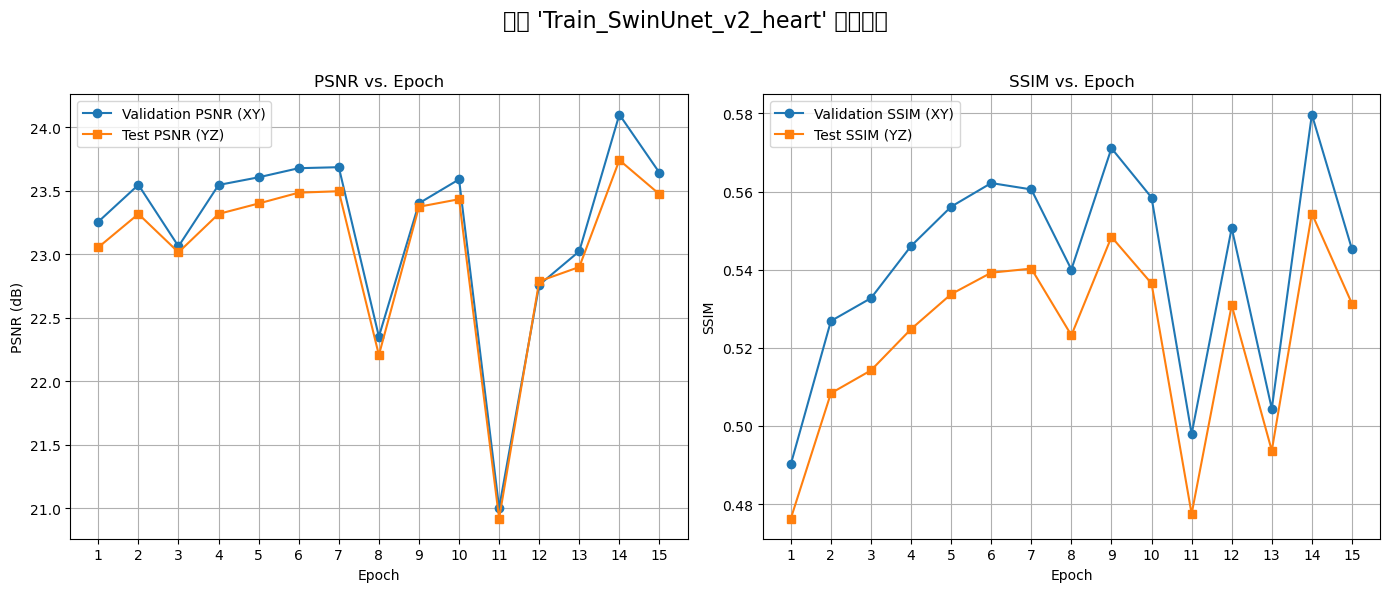

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import cv2
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------------------
# 1. 定义模型和 Dataset 类 (与训练时完全一致)
# ----------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.up4, self.dec4 = UpBlockPixelShuffle(encoder_channels[3], 512), DoubleConv(encoder_channels[2] + 512, 512)
        self.up3, self.dec3 = UpBlockPixelShuffle(512, 256), DoubleConv(encoder_channels[1] + 256, 256)
        self.up2, self.dec2 = UpBlockPixelShuffle(256, 128), DoubleConv(encoder_channels[0] + 128, 128)
        self.up1, self.dec1 = UpBlockPixelShuffle(128, 64), DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)
    def forward(self, x):
        x_orig = x
        if self.in_ch == 1: x = x.repeat(1, 3, 1, 1)
        features = self.encoder(x)
        e1, e2, e3, e4 = features[0].permute(0, 3, 1, 2), features[1].permute(0, 3, 1, 2), features[2].permute(0, 3, 1, 2), features[3].permute(0, 3, 1, 2)
        u4, d4 = self.up4(e4), self.dec4(torch.cat([self.up4(e4), e3], dim=1))
        u3, d3 = self.up3(d4), self.dec3(torch.cat([self.up3(d4), e2], dim=1))
        u2, d2 = self.up2(d3), self.dec2(torch.cat([self.up2(d3), e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        return self.outc(d1)

class PlainLowHighDataset(Dataset):
    def __init__(self, patches_folder, indices, all_fns_list, transform=None):
        super().__init__()
        self.patches_folder, self.transform = patches_folder, transform or transforms.ToTensor()
        self.fns = [all_fns_list[i] for i in indices]
    def __len__(self): return len(self.fns)
    def __getitem__(self, idx):
        fn = self.fns[idx]
        img_path = os.path.join(self.patches_folder, fn)
        arr = np.array(Image.open(img_path).convert("L"))
        down_arr = cv2.resize(arr, (256, 32), interpolation=cv2.INTER_AREA)
        up_img = cv2.resize(down_arr, (256, 256), interpolation=cv2.INTER_LINEAR)
        inp_t = self.transform(Image.fromarray(up_img))
        tgt_t = self.transform(Image.fromarray(arr))
        return inp_t, tgt_t

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()
checkpoint_dir = "Train_SwinUnet_v2_heart" # <-- 使用SwinUnet的权重文件夹
num_epochs = 15

# 准备 Dataloaders
val_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_xy"
all_val_fns = sorted([f for f in os.listdir(val_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_val_indices = list(range(len(all_val_fns)))
_, val_idxs = train_test_split(all_val_indices, test_size=0.25, random_state=42)
val_dataset = PlainLowHighDataset(val_patches_folder, val_idxs, all_val_fns, transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_patches_folder = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_yz"
all_test_fns = sorted([f for f in os.listdir(test_patches_folder) if f.lower().endswith((".jpg", ".png"))])
all_test_indices = list(range(len(all_test_fns)))
test_dataset = PlainLowHighDataset(test_patches_folder, all_test_indices, all_test_fns, transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------------------
# 3. 定义评估函数
# ----------------------------------------
def evaluate_model(model, loader):
    total_psnr = total_ssim = n = 0
    model.eval()
    with torch.no_grad():
        for inp_t, tgt_t in loader:
            inp_t, tgt_t = inp_t.to(device), tgt_t.to(device)
            out_t = model(inp_t)
            
            pred_np = out_t.clamp(0, 1).cpu().squeeze().numpy()
            target_np = tgt_t.cpu().squeeze().numpy()
            
            total_psnr += psnr_metric(target_np, pred_np, data_range=1.0)
            total_ssim += ssim_metric(target_np, pred_np, data_range=1.0, channel_axis=None)
            n += 1
    return total_psnr / n, total_ssim / n

# ----------------------------------------
# 4. 循环评估所有Epoch并记录结果
# ----------------------------------------
epochs = list(range(1, num_epochs + 1))
val_psnrs, val_ssims = [], []
test_psnrs, test_ssims = [], []

print(f"开始在 {device} 上评估 '{checkpoint_dir}' 的所有模型...")

for epoch in tqdm(epochs, desc="评估进度"):
    # 构建权重文件路径，注意文件名格式
    ckpt_path = os.path.join(checkpoint_dir, f"SwinUnet_v2_hf_epoch{epoch:02d}.pth")
    
    # 实例化新模型并加载权重
    model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    
    # 在验证集和测试集上评估
    vp, vs = evaluate_model(model, val_loader)
    tp, ts = evaluate_model(model, test_loader)
    
    # 记录结果
    val_psnrs.append(vp)
    val_ssims.append(vs)
    test_psnrs.append(tp)
    test_ssims.append(ts)

# ----------------------------------------
# 5. 打印表格形式的结果
# ----------------------------------------
print("\n--- 评估结果汇总 ---")
print("="*60)
print(f"{'Epoch':<10}{'Val PSNR':<15}{'Val SSIM':<15}{'Test PSNR':<15}{'Test SSIM':<15}")
print("-"*60)
for i in range(num_epochs):
    print(f"{i+1:<10}{val_psnrs[i]:<15.4f}{val_ssims[i]:<15.4f}{test_psnrs[i]:<15.4f}{test_ssims[i]:<15.4f}")
print("="*60)


# ----------------------------------------
# 6. 绘制结果图表
# ----------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_psnrs, 'o-', label='Validation PSNR (XY)')
plt.plot(epochs, test_psnrs, 's-', label='Test PSNR (YZ)')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_ssims, 'o-', label='Validation SSIM (XY)')
plt.plot(epochs, test_ssims, 's-', label='Test SSIM (YZ)')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM vs. Epoch')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.suptitle(f"模型 '{checkpoint_dir}' 性能评估", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import cv2
import timm
from torchvision import transforms

# ----------------------------------------
# 1. 定义与训练时完全一致的模型架构
# ----------------------------------------
# 确保这些定义与您训练模型时的代码完全相同
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlockPixelShuffle(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.pixel_shuffle(self.conv(x)))

class SwinUnet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, pretrained=True):
        super().__init__()
        self.in_ch = in_ch
        self.encoder = timm.create_model(
            'swin_tiny_patch4_window7_224', pretrained=pretrained, features_only=True,
            in_chans=3, img_size=256
        )
        encoder_channels = self.encoder.feature_info.channels()
        self.up4, self.dec4 = UpBlockPixelShuffle(encoder_channels[3], 512), DoubleConv(encoder_channels[2] + 512, 512)
        self.up3, self.dec3 = UpBlockPixelShuffle(512, 256), DoubleConv(encoder_channels[1] + 256, 256)
        self.up2, self.dec2 = UpBlockPixelShuffle(256, 128), DoubleConv(encoder_channels[0] + 128, 128)
        self.up1, self.dec1 = UpBlockPixelShuffle(128, 64), DoubleConv(64 + in_ch, 64)
        self.outc = nn.Conv2d(64, out_ch, kernel_size=1)
    def forward(self, x):
        x_orig = x
        if self.in_ch == 1: x = x.repeat(1, 3, 1, 1)
        features = self.encoder(x)
        e1, e2, e3, e4 = features[0].permute(0, 3, 1, 2), features[1].permute(0, 3, 1, 2), features[2].permute(0, 3, 1, 2), features[3].permute(0, 3, 1, 2)
        u4 = self.up4(e4)
        d4 = self.dec4(torch.cat([u4, e3], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e2], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e1], dim=1))
        u1 = self.up1(d2)
        final_up = F.interpolate(u1, scale_factor=2, mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([final_up, x_orig], dim=1))
        return self.outc(d1)

# ----------------------------------------
# 2. 设置路径和参数
# ----------------------------------------
# 假设 block32_yz_003.jpg 在 "test_patches_YZ" 文件夹中
IMAGE_PATH = r"C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_yz\block32_yz_003.jpg"
CHECKPOINT_DIR = "Train_SwinUnet_v2_heart"
EPOCH_TO_LOAD = 14
OUTPUT_DIR = "CROSS_HEART_test"

os.makedirs(OUTPUT_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()

# ----------------------------------------
# 3. 加载模型权重
# ----------------------------------------
model = SwinUnet(in_ch=1, out_ch=1, pretrained=False).to(device) # pretrained=False,因为我们要加载自己的权重
checkpoint_filename = f"SwinUnet_v2_hf_epoch{EPOCH_TO_LOAD:02d}.pth"
checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"成功加载模型权重: {checkpoint_path}")

# ----------------------------------------
# 4. 加载和预处理图像
# ----------------------------------------
# 加载原始高分辨率图像 (Ground Truth)
gt_image_pil = Image.open(IMAGE_PATH).convert("L")
gt_image_np = np.array(gt_image_pil)
gt_tensor = transform(gt_image_pil).unsqueeze(0).to(device)

print(f"已加载图像: {IMAGE_PATH}")

# 创建模型的低分辨率输入
# 1. 归一化到 [0, 1]
gt_image_float = gt_image_np.astype(np.float32) / 255.0
# 2. 垂直下采样8倍
lr_image_np = cv2.resize(gt_image_float, (256, 32), interpolation=cv2.INTER_AREA)
# 3. 线性插值回原始尺寸
input_image_np = cv2.resize(lr_image_np, (256, 256), interpolation=cv2.INTER_LINEAR)
# 4. 转换为Tensor
input_tensor = torch.from_numpy(input_image_np).unsqueeze(0).unsqueeze(0).to(device)

print("已生成模型的低分辨率输入。")

# ----------------------------------------
# 5. 执行模型推理
# ----------------------------------------
with torch.no_grad():
    output_tensor = model(input_tensor)
print("模型推理完成。")

# ----------------------------------------
# 6. 保存结果图像
# ----------------------------------------
def tensor_to_image(tensor):
    """将 [0,1] 范围的Tensor转换为可保存的PIL Image对象"""
    arr = tensor.clamp(0, 1).cpu().squeeze().numpy()
    return Image.fromarray((arr * 255).round().astype(np.uint8))

# 获取不带后缀的文件名
base_name = os.path.splitext(os.path.basename(IMAGE_PATH))[0]

# 保存三张图片
path_input = os.path.join(OUTPUT_DIR, f"{base_name}_01_input.png")
path_output = os.path.join(OUTPUT_DIR, f"{base_name}_02_reconstructed.png")
path_gt = os.path.join(OUTPUT_DIR, f"{base_name}_03_ground_truth.png")

tensor_to_image(input_tensor).save(path_input)
tensor_to_image(output_tensor).save(path_output)
tensor_to_image(gt_tensor).save(path_gt)

print(f"\n结果已保存至 '{OUTPUT_DIR}/' 文件夹:")
print(f"  - 输入图像: {path_input}")
print(f"  - 重建图像: {path_output}")
print(f"  - 原始图像: {path_gt}")

C:\Users\Alpaca_YT\AppData\Local\Temp\ipykernel_39412\3919963109.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_l

成功加载模型权重: Train_SwinUnet_v2_heart\SwinUnet_v2_hf_epoch14.pth
已加载图像: C:\Users\Alpaca_YT\pythonSet\lung_slices_dataset\lung_slice_yz\block32_yz_003.jpg
已生成模型的低分辨率输入。
模型推理完成。

结果已保存至 'CROSS_HEART_test/' 文件夹:
  - 输入图像: CROSS_HEART_test\block32_yz_003_01_input.png
  - 重建图像: CROSS_HEART_test\block32_yz_003_02_reconstructed.png
  - 原始图像: CROSS_HEART_test\block32_yz_003_03_ground_truth.png
